In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, desc, avg, year, length, split, explode, udf
from pyspark.sql.types import ArrayType, StringType, FloatType
from pyspark.sql.functions import explode

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
spark = SparkSession.builder.appName("Amazon_book_reviews_project").getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
books_data_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- image: string (nullable = true)
 |-- previewLink: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- publishedDate: string (nullable = true)
 |-- infoLink: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- ratingsCount: string (nullable = true)

In [ ]:
books_rating_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

# Data Preparation

In [ ]:
print("Books Data Count:", books_data_df.count())
print("Books Rating Data Count:", books_rating_df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Books Data Count: 212404
Books Rating Data Count: 3000000

# Checking for Null/empty values of Books data df

In [ ]:
null_counts_books_data = books_data_df.select([count(when(col(c).isNull(), c)).alias(c) for c in books_data_df.columns]).collect()[0].asDict()
print("Null counts for books_data_df:")
for col_name, null_count in null_counts_books_data.items():
    print(f"{col_name} : {null_count}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Null counts for books_data_df:
Title : 1
description : 68357
authors : 31251
image : 51191
previewLink : 24055
publisher : 73130
publishedDate : 25844
infoLink : 24301
categories : 40524
ratingsCount : 148552

# Inspecting important columns of books_data_df
The columns of interest in books_data df are
1. ratingsCount
2. catgeories
3. Title

All of these columns should have proper values. The rows having invalid values ffor these columns should be eliminated as they will not be helping us to extract any meaningful information

In [ ]:
# Number of ratings_count_columns having invalid values
invalid_ratings_count = books_data_df.filter(~col("ratingsCount").rlike("^[0-9]*\\.?[0-9]+$")).count()
invalid_ratings_count

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

20426

In [ ]:
# Replacing all non-numeric invalid values with None
books_data_df = books_data_df.withColumn("ratingsCount", when(col("ratingsCount").rlike("^[0-9]*\\.?[0-9]+$"), col("ratingsCount")).otherwise(0.0))
# Cast ratingsCount to float
books_data_df = books_data_df.withColumn("ratingsCount", col("ratingsCount").cast("float"))
# filling zeros which have None values for ratings count
books_data_df = books_data_df.fillna({"ratingsCount": 0.0})

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Cleaning categories column
Ideally categories column should be of array type containing list of categories. In the given dataset it has type string and many records contain invalid values.
The below UDF converts it to a valid array and for those records which invalid values, it replaces them with an empty array

In [ ]:
import ast
def convert_string_to_list(col_value):
    transformed_val = []
    if isinstance(col_value, str):
        try:
            transformed_val = ast.literal_eval(col_value)
        except:
            transformed_val = []
    return transformed_val

convert_string_to_list_udf = udf(convert_string_to_list, ArrayType(StringType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
books_data_df = books_data_df.withColumn("categories", convert_string_to_list_udf(books_data_df["categories"]))
books_data_df.select(col('categories')).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|          categories|
+--------------------+
|[Comics & Graphic...|
|                  []|
|          [Religion]|
|           [Fiction]|
|                  []|
|          [Religion]|
|                  []|
|                  []|
|[Biography & Auto...|
|    [Social Science]|
|          [Religion]|
|         [Reference]|
|[Juvenile Nonfict...|
|[Allen Gersho, Ro...|
|           [History]|
|[New Zealand fict...|
|               [Law]|
|                  []|
|  [Health & Fitness]|
|                  []|
+--------------------+
only showing top 20 rows

In [ ]:
exploded_df = books_data_df.select("Title", explode("categories").alias("category"))
category_counts = exploded_df.groupBy("category").count().orderBy("count", ascending=False)
rows = category_counts.collect()
category_names = []
counts = []
for row in rows:
    if (row['category'] != '' or row['category'] is not None) and row['count'] >= 1000:
        category_names.append(row['category'])
        counts.append(row['count'])
print(str(category_names))
print('-------------------------------')
print(str(counts))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['Fiction', 'Religion', 'History', 'Juvenile Fiction', 'Biography & Autobiography', 'Business & Economics', 'Computers', 'Social Science', 'Juvenile Nonfiction', 'Science', 'Education', 'Cooking', 'Sports & Recreation', 'Medical', 'Music', 'Family & Relationships', 'Art', 'Literary Criticism', 'Language Arts & Disciplines', 'Health & Fitness', 'Body, Mind & Spirit', 'Political Science', 'Psychology', 'Travel', 'Philosophy', 'Technology & Engineering', 'Foreign Language Study', 'Crafts & Hobbies', 'Self-Help', 'Poetry', 'Reference', 'Performing Arts', 'Mathematics', 'Comics & Graphic Novels', 'Nature']
-------------------------------
[20020, 7923, 7882, 6088, 5207, 4663, 3659, 3212, 3190, 2346, 2297, 2158, 1975, 1828, 1823, 1814, 1796, 1791, 1751, 1726, 1705, 1611, 1588, 1586, 1541, 1492, 1278, 1229, 1180, 1167, 1149, 1102, 1042, 1032, 1028]

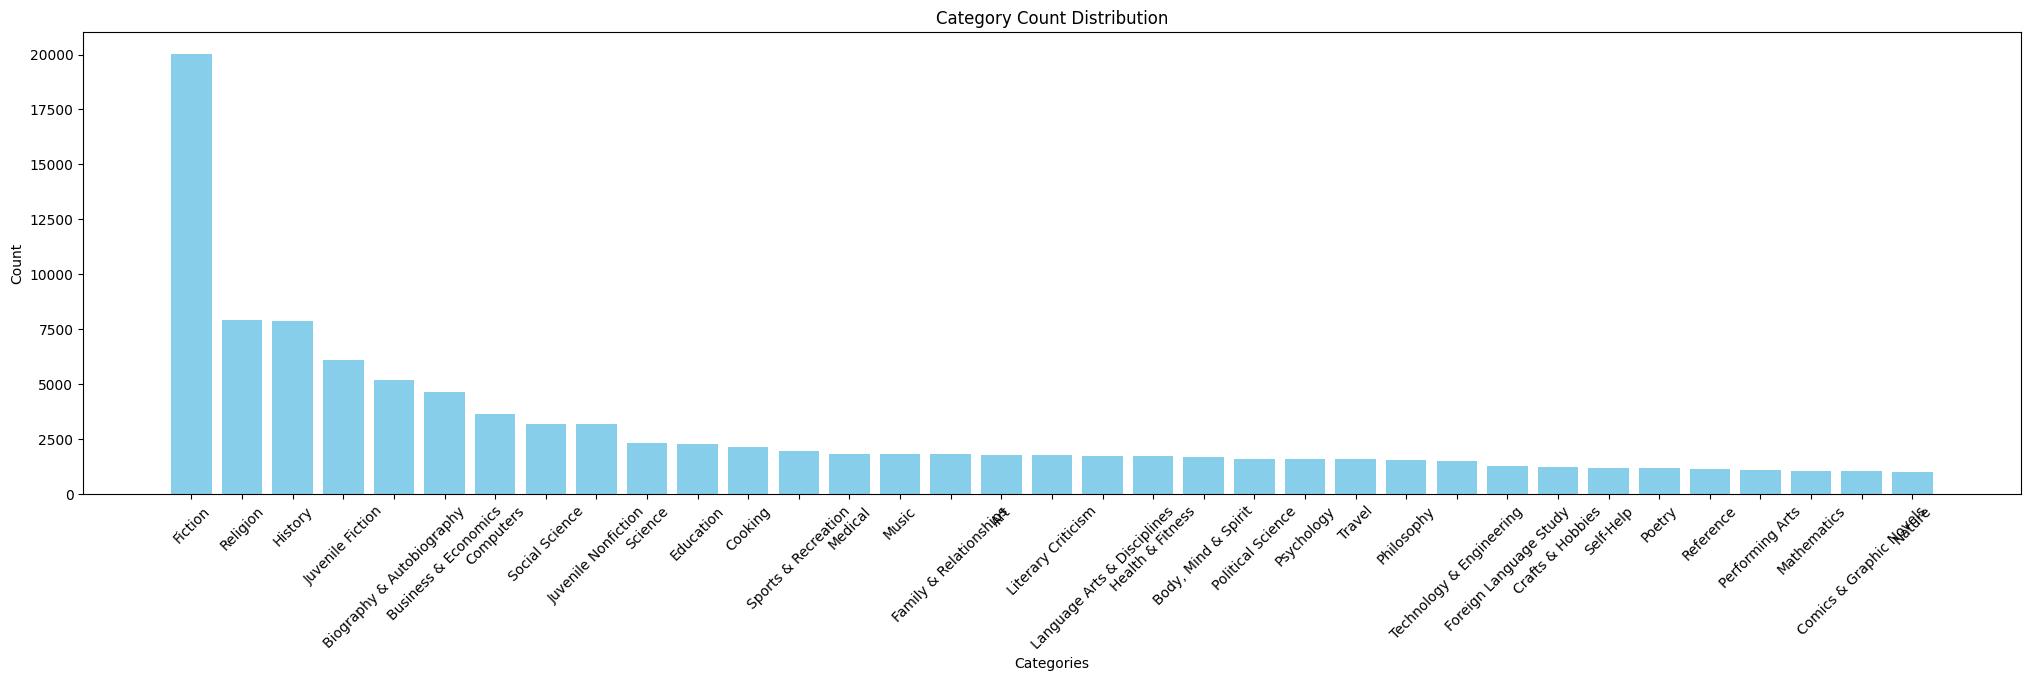

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 6))
plt.bar(category_names, counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Category Count Distribution')
plt.xticks(rotation=45)
plt.show()

# Cleaning Title column
Finding out how many rows have title column empty. These should be dropped because any information pertaining to a book which has no information about the title present is totally irrelvant.

In [ ]:
count_before_dropping_null_titles = books_data_df.count()
books_data_df.na.drop(subset=['Title'])
count_after_dropping_null_titles = books_data_df.count()
print(f"row count before dropping null titles: {count_before_dropping_null_titles}, row count after dropping null titles: {count_after_dropping_null_titles}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

row count before dropping null titles: 212404, row count after dropping null titles: 212404

## Therefore, no record has empty title in books_data_df

# Inspecting important columns of books_rating_df

The columns of interest in books_rating_df are

1. Title
2. Price
3. review/helpfulness
4. review/score
5. review/time
6. review/summary
7. review/text

All of these columns are of type string. But since review/score , review/helpfulness are essentially scores. we should normalize and/or scale them to some meaningful Range.

But first, lets check the number of empty values in each column of books_rating_df

In [ ]:
null_counts_books_rating = books_rating_df.select([count(when(col(c).isNull(), c)).alias(c) for c in books_rating_df.columns]).collect()[0].asDict()
print("\nNull counts for books_rating_df:")
for col_name, null_count in null_counts_books_rating.items():
    print(f"{col_name} : {null_count}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Null counts for books_rating_df:
Id : 0
Title : 208
Price : 2517579
User_id : 562250
profileName : 562200
review/helpfulness : 367
review/score : 130
review/time : 27
review/summary : 65
review/text : 43

# Normalizing review/score column of books_rating_df

1. Scaled all values in the 0-5 range
2. Values which are null or invalid have been replaced with 0.0

In [ ]:

def normalize_fraction(s, index_of_divide_operator):
    try:
        if index_of_divide_operator > -1:
            numerator = float(s[:index_of_divide_operator].strip())
            denominator = float(s[index_of_divide_operator+1:].strip())
            return (numerator * 5/ denominator) if denominator > 0.0 else 0.0
        else:
            return 0.0
    except:
        return 0.0

def convert_string_to_float(val):
    if val is not None and isinstance(val, float) and val >=0 and val <=5:
        return val
    float_val = 0.0
    if val is not None and isinstance(val, str):
        try:
            float_val = float(val)
            float_val = float_val if float_val >=0 and float_val <=5 else 0.0
        except:
            index_of_divide_operator = val.find('/')
            float_val = normalize_fraction(val, index_of_divide_operator)
    return float_val

normalize_string_to_float_udf = udf(convert_string_to_float, FloatType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
books_rating_df = books_rating_df.withColumn("review/score", normalize_string_to_float_udf(books_rating_df["review/score"]))
books_rating_df.select(col('review/score')).show()
books_rating_df.printSchema()
null_counts_books_review_score = books_rating_df.select(count(when(col('review/score').isNull(), 'review/score')).alias('Num of Null values in review/score column'))
null_counts_books_review_score.show()
hist_data = books_rating_df.select("review/score").rdd.flatMap(lambda x: x).histogram([0, 1, 2, 3, 4, 5])

# Display bin counts
review_score_bin_ranges = hist_data[0]
review_score_counts = hist_data[1]

# Show results in tabular form
for i in range(len(review_score_counts)):
    print(f"Bin {review_score_bin_ranges[i]} to {review_score_bin_ranges[i+1]}: Count = {review_score_counts[i]}")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|review/score|
+------------+
|         4.0|
|         5.0|
|         5.0|
|         4.0|
|         4.0|
|         4.0|
|         5.0|
|         5.0|
|         5.0|
|         4.0|
|         5.0|
|         5.0|
|         5.0|
|         5.0|
|         1.0|
|         4.0|
|         1.0|
|         5.0|
|         5.0|
|         5.0|
+------------+
only showing top 20 rows

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: float (nullable = true)
 |-- review/score: float (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

+-----------------------------------------+
|Num of Null values in review/score column|
+-----------------------------------------+
|                                        0|
+-----------------

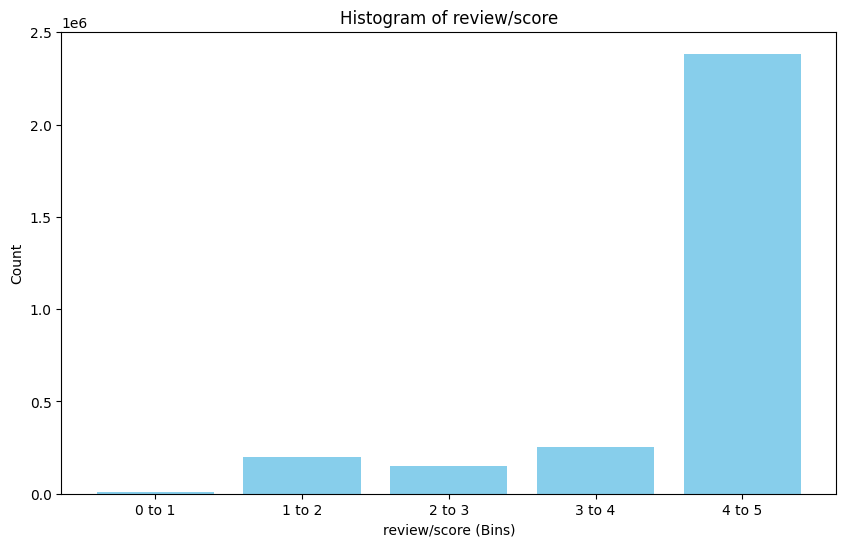

In [ ]:
import matplotlib.pyplot as plt

# Define the bins and their counts
bins = ["0 to 1", "1 to 2", "2 to 3", "3 to 4", "4 to 5"]
counts = [8820, 201571, 151599, 254377, 2383633]

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.bar(bins, counts, color="skyblue")
plt.xlabel("review/score (Bins)")
plt.ylabel("Count")
plt.title("Histogram of review/score")
plt.show()

# Normalizing review/helpfulness column
1. Will leverage the normalize_string_to_float_udf to transform all strings to value scaled between 0 and 5
2. Rest of the values will be padded with 0

In [ ]:
books_rating_df = books_rating_df.withColumn("review/helpfulness", normalize_string_to_float_udf(books_rating_df["review/helpfulness"]))
books_rating_df.select(col('review/helpfulness')).show()
books_rating_df.printSchema()
null_counts_books_review_score = books_rating_df.select(count(when(col('review/helpfulness').isNull(), 'review/helpfulness')).alias('Num of Null values in review/helpfulness column'))
null_counts_books_review_score.show()
hist_data = books_rating_df.select("review/helpfulness").rdd.flatMap(lambda x: x).histogram([0, 1, 2, 3, 4, 5])

# Display bin counts
review_helpfulness_bin_ranges = hist_data[0]
review_helpfulness_counts = hist_data[1]

# Show results in tabular form
for i in range(len(counts)):
    print(f"Bin {review_helpfulness_bin_ranges[i]} to {review_helpfulness_bin_ranges[i+1]}: Count = {review_helpfulness_counts[i]}")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|review/helpfulness|
+------------------+
|               5.0|
|               5.0|
|         4.5454545|
|               5.0|
|               5.0|
|               5.0|
|              3.75|
|               0.0|
|               0.0|
|               3.0|
|               4.0|
|               5.0|
|               5.0|
|               5.0|
|         3.1818182|
|               2.5|
|               2.5|
|               2.5|
|         2.7777777|
|         1.6666666|
+------------------+
only showing top 20 rows

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: float (nullable = true)
 |-- review/score: float (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

+-----------------------------------------------+


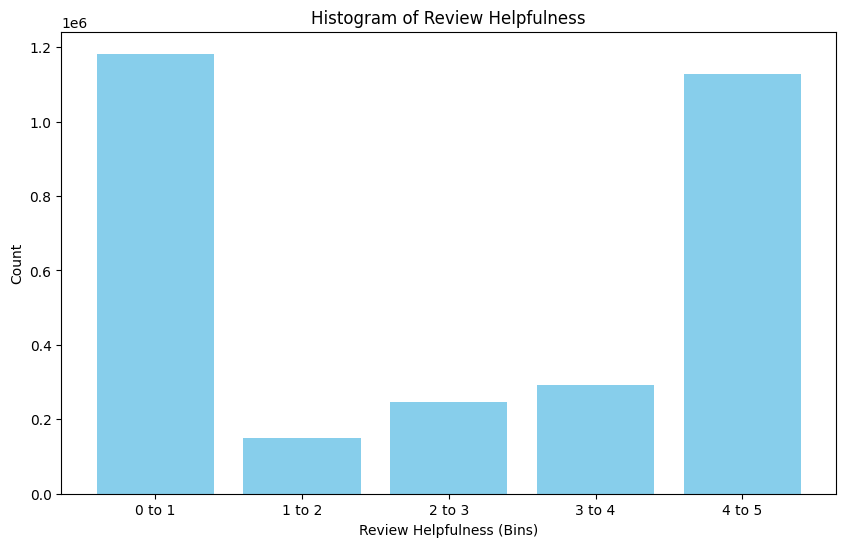

In [ ]:
import matplotlib.pyplot as plt

# Define the bins and their counts
bins = ["0 to 1", "1 to 2", "2 to 3", "3 to 4", "4 to 5"]
counts = [1182589, 149972, 247809, 291851, 1127779]

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.bar(bins, counts, color="skyblue")
plt.xlabel("Review Helpfulness (Bins)")
plt.ylabel("Count")
plt.title("Histogram of Review Helpfulness")
plt.show()

# Checking null values for every column after normalization

In [ ]:
null_counts_books_rating = books_rating_df.select([count(when(col(c).isNull(), c)).alias(c) for c in books_rating_df.columns]).collect()[0].asDict()
print("\nNull counts for books_rating_df:")
for col_name, null_count in null_counts_books_rating.items():
    print(f"{col_name} : {null_count}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Null counts for books_rating_df:
Id : 0
Title : 208
Price : 2517579
User_id : 562250
profileName : 562200
review/helpfulness : 0
review/score : 0
review/time : 27
review/summary : 65
review/text : 43